## Introduction
Universities across the U.S. are experiencing an unprecedented rise in student mental-health challenges, with nearly half of undergraduates reporting symptoms of depression and over a third reporting anxiety. As counseling centers face increased demand and limited resources, institutions often struggle to identify at-risk students before their symptoms escalate. With the growing availability of student data and advances in predictive modeling, there is a major opportunity to shift from reactive crisis response to proactive early intervention.
Our project explores how data-driven approaches—specifically machine learning—can help universities detect early indicators of anxiety and depression, allowing support services to intervene sooner and more effectively.





## Objective:
The objective of this project is to determine which predictive modeling approach most effectively identifies students who may be at risk for anxiety and depression, using only non-psychiatric data such as demographic information, general health indicators, lifestyle factors, and academic variables. The long-term goal is to guide the development of an early intervention system that universities could use to deliver timely outreach, reduce counseling wait times, and improve overall student wellbeing. Through exploratory data analysis, feature engineering, and the evaluation of multiple machine-learning classifiers, we aim to show how data-driven insights can support proactive mental-health strategies in higher education.

In [13]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-depression-dataset' dataset.
Path to dataset files: /kaggle/input/student-depression-dataset


In [15]:

data = pd.read_csv(path + '/student_depression_dataset.csv')
data.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [16]:
# Clean Data
# Rename Columns
data = data.rename(columns={'CGPA':'Cumulative GPA'})
data = data.rename(columns={'Have you ever had suicidal thoughts ?' : 'Suicidal thoughts'})
data = data.rename(columns={'Family History of Mental Illness': 'Mental Illness History'})

# Clean column names
data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('?', '').str.replace('/', '_')

# Clean columns value text
#removing blank spaces
data.columns=data.columns.str.replace(' ', '_')
data.replace(' ','_', regex=True, inplace=True)
#removing '' from the sleep duaration output
data['Sleep_Duration'] = data['Sleep_Duration'].str.replace("'", "", regex=False)

# Drop columns too granular
data = data.drop(columns=['id', 'City'], errors='ignore')

# Assign Columns to feature and target variables
X = data.drop('Depression', axis = 1).copy() # Features
y = data['Depression'].copy() # Target

# One hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.head()

,Age,Academic_Pressure,Work_Pressure,Cumulative_GPA,Study_Satisfaction,Job_Satisfaction,Work_Study_Hours,Gender_Male,Profession_'Content_Writer',Profession_'Digital_Marketer',...,Degree_MSc,Degree_Others,Degree_PhD,Suicidal_thoughts_Yes,Financial_Stress_2.0,Financial_Stress_3.0,Financial_Stress_4.0,Financial_Stress_5.0,Financial_Stress_?,Mental_Illness_History_Yes
0,33.0,5.0,0.0,8.97,2.0,0.0,3.0,True,False,False,...,False,False,False,True,False,False,False,False,False,False
1,24.0,2.0,0.0,5.90,5.0,0.0,3.0,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,31.0,3.0,0.0,7.03,5.0,0.0,9.0,True,False,False,...,False,False,False,False,False,False,False,False,False,True
3,28.0,3.0,0.0,5.59,2.0,0.0,4.0,False,False,False,...,False,False,False,True,False,False,False,True,False,True
4,25.0,4.0,0.0,8.13,3.0,0.0,1.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False


## Exploratory Data Analysis (EDA)

**Key Risk Factors:**


*   Academic Pressure - A strong positive correlation was found between the level of academic pressure reported by a student and their likelihood of experiencing depression.

*   Work/Study Hours - Students working 10 hours per week showed the highest depression rates. Conversely, those working a more moderate 1-5 hours had the lowest rates.

*   Sleep Duration -  Sleep is a major factor. The highest rate of depression is linked to students getting less than 5 hours of sleep per night, with the lowest rate among those getting 7-8 hours.


In [ ]:
data.shape

(27901, 16)

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,27901.0,25.822300,4.905687,18.0,21.00,25.00,30.00,59.0
Academic_Pressure,27901.0,3.141214,1.381465,0.0,2.00,3.00,4.00,5.0
Work_Pressure,27901.0,0.000430,0.043992,0.0,0.00,0.00,0.00,5.0
Cumulative_GPA,27901.0,7.656104,1.470707,0.0,6.29,7.77,8.92,10.0
Study_Satisfaction,27901.0,2.943837,1.361148,0.0,2.00,3.00,4.00,5.0
Job_Satisfaction,27901.0,0.000681,0.044394,0.0,0.00,0.00,0.00,4.0
Work_Study_Hours,27901.0,7.156984,3.707642,0.0,4.00,8.00,10.00,12.0
Depression,27901.0,0.585499,0.492645,0.0,0.00,1.00,1.00,1.0


### Bivariate Analysis

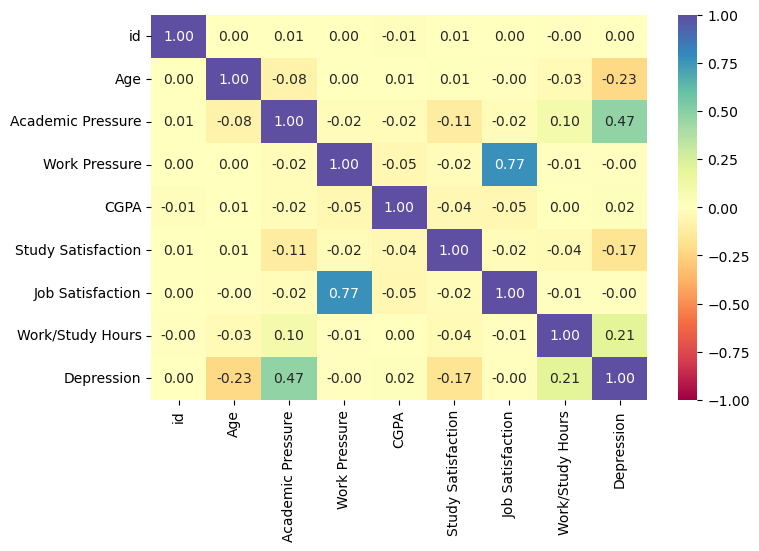

## Model Building


In [17]:
# Prep Data for Modeling
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42)


**Model 1:** Bagging Classifier

Bagging or Bootstrap Aggregating, works by training multiple base models independently and in parallel on different random subsets of the training data.

In [18]:
# Bagging Classifier with Decision Tree estimator
bagging = BaggingClassifier(
    estimator = DecisionTreeClassifier(max_depth=6),
    n_estimators = 100,
    random_state = 42
)
# Fit the Model
bagging.fit(X_train, y_train)

# Predict
y_pred_bag = bagging.predict(X_test)

**Model 2:** Decision Tree Classifier

A decision tree is a supervised learning algorithm used for both classification and regression tasks. It has a hierarchical tree structure which consists of a root node, branches, internal nodes and leaf nodes.

In [19]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
DecisionTreeClassifier(random_state=42)
y_pred_dt = clf.predict(X_test)

**Model 3:** Random Forest Classifier

Random Forest is a machine learning algorithm that uses many decision trees to make better predictions. Each tree looks at different random parts of the data and their results are combined by voting for classification or averaging for regression which makes it as ensemble learning technique.

In [20]:
# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

**Model 4:** XGBoost Classifier

XGBoost short form for eXtreme Gradient Boosting is an advanced machine learning algorithm designed for efficiency, speed and high performance.

In [21]:
clf_xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=1000,
    early_stopping_rounds=10,
    eval_metric='aucpr'
)
clf_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

y_pred_xgb = clf_xgb.predict(X_test)

[0]	validation_0-aucpr:0.90725
[1]	validation_0-aucpr:0.91457
[2]	validation_0-aucpr:0.91798
[3]	validation_0-aucpr:0.92191
[4]	validation_0-aucpr:0.92422
[5]	validation_0-aucpr:0.92880
[6]	validation_0-aucpr:0.92985
[7]	validation_0-aucpr:0.93024
[8]	validation_0-aucpr:0.93124
[9]	validation_0-aucpr:0.93204
[10]	validation_0-aucpr:0.93270
[11]	validation_0-aucpr:0.93290
[12]	validation_0-aucpr:0.93318
[13]	validation_0-aucpr:0.93347
[14]	validation_0-aucpr:0.93342
[15]	validation_0-aucpr:0.93320
[16]	validation_0-aucpr:0.93353
[17]	validation_0-aucpr:0.93353
[18]	validation_0-aucpr:0.93384
[19]	validation_0-aucpr:0.93393
[20]	validation_0-aucpr:0.93365
[21]	validation_0-aucpr:0.93364
[22]	validation_0-aucpr:0.93344
[23]	validation_0-aucpr:0.93344
[24]	validation_0-aucpr:0.93346
[25]	validation_0-aucpr:0.93316
[26]	validation_0-aucpr:0.93308
[27]	validation_0-aucpr:0.93325
[28]	validation_0-aucpr:0.93309
[29]	validation_0-aucpr:0.93327


## Evaluation Metrics

Bagging Model Evaluation Metrics

In [22]:
print("Accuracy: ", accuracy_score(y_test, y_pred_bag))
print("Classification Report:\n",classification_report(y_test, y_pred_bag))

Accuracy:  0.8260661808625015
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      3505
           1       0.84      0.87      0.85      4866

    accuracy                           0.83      8371
   macro avg       0.82      0.82      0.82      8371
weighted avg       0.83      0.83      0.83      8371



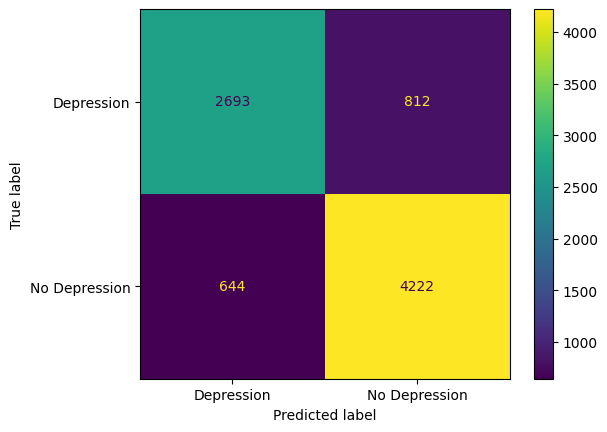

In [23]:
# Checking how well it actually preforms on the test dataset
ConfusionMatrixDisplay.from_estimator(bagging,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Depression","No Depression"])

Decision Tree Evaluation Metrics

In [24]:
print("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n",classification_report(y_test, y_pred_dt))

Accuracy:  0.7658583203918289
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.72      3505
           1       0.80      0.79      0.80      4866

    accuracy                           0.77      8371
   macro avg       0.76      0.76      0.76      8371
weighted avg       0.77      0.77      0.77      8371



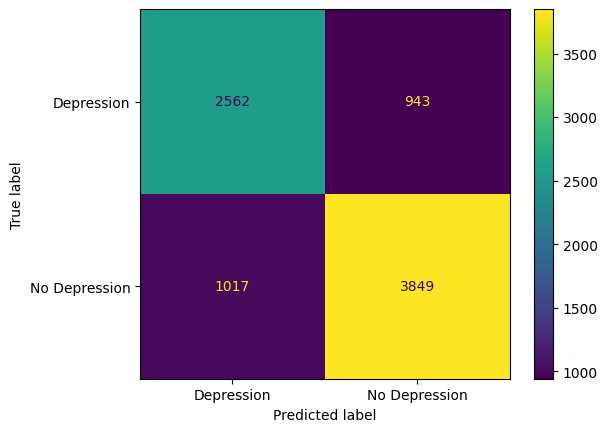

In [25]:
# Checking how well it actually preforms on the test dataset
ConfusionMatrixDisplay.from_estimator(clf,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Depression","No Depression"])

Random Forest Evaluation Metrics






In [26]:
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n",classification_report(y_test, y_pred_rf))

Accuracy:  0.8310835025683909
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79      3505
           1       0.85      0.87      0.86      4866

    accuracy                           0.83      8371
   macro avg       0.83      0.82      0.83      8371
weighted avg       0.83      0.83      0.83      8371



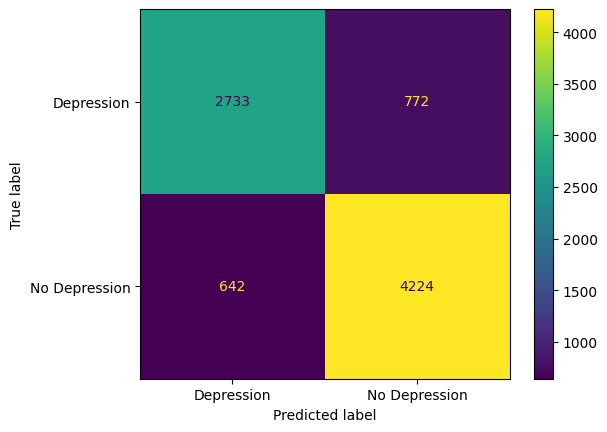

In [27]:
# Checking how well it actually preforms on the test dataset
ConfusionMatrixDisplay.from_estimator(rf,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Depression","No Depression"])

XGBoost Evaluation Metrics

In [28]:
print("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n",classification_report(y_test, y_pred_xgb))

Accuracy:  0.837175964639828
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      3505
           1       0.85      0.87      0.86      4866

    accuracy                           0.84      8371
   macro avg       0.83      0.83      0.83      8371
weighted avg       0.84      0.84      0.84      8371



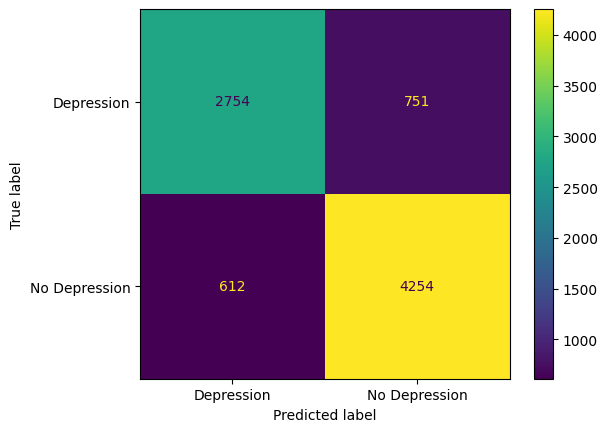

In [29]:
# Checking how well it actually preforms on the test dataset
ConfusionMatrixDisplay.from_estimator(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Depression","No Depression"])

# XGboost Shap - Best Performing


In [ ]:
# Initialize a TreeExplainer for the XGBoost model
explainer = shap.TreeExplainer(clf_xgb)

# Calculate SHAP values for the data
xgbshap_values = explainer.shap_values(X_test)

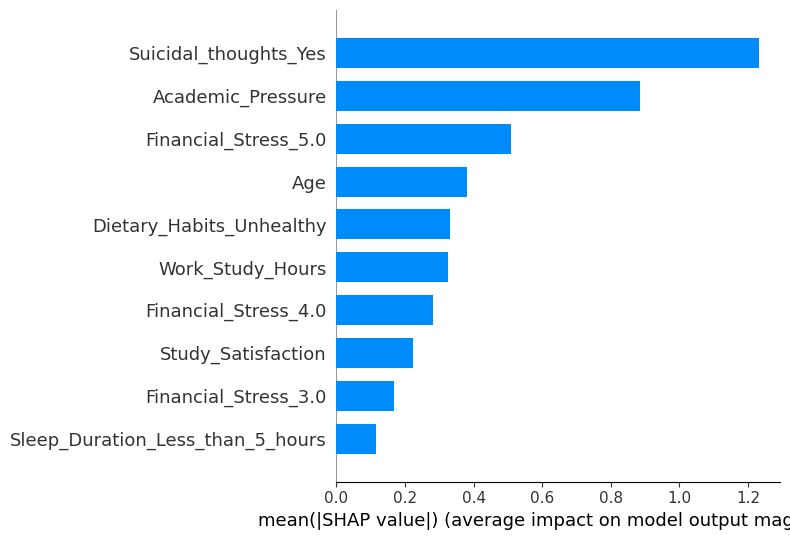

In [ ]:
# Summary Plot -- Bar Chart
shap.summary_plot(xgbshap_values, X_test, plot_type="bar", feature_names=X_encoded.columns, max_display= 10)

## Bagging

In [ ]:
# SHAP Values for Bagging Classifier
all_shap_values = []

for est in bagging.estimators_:
    explainer = shap.TreeExplainer(est)
    values = explainer.shap_values(X_test)
    all_shap_values.append(values)

mean_shap = np.mean(np.array(all_shap_values), axis=0)
shap_values_class1_bag = mean_shap[:, :, 1]

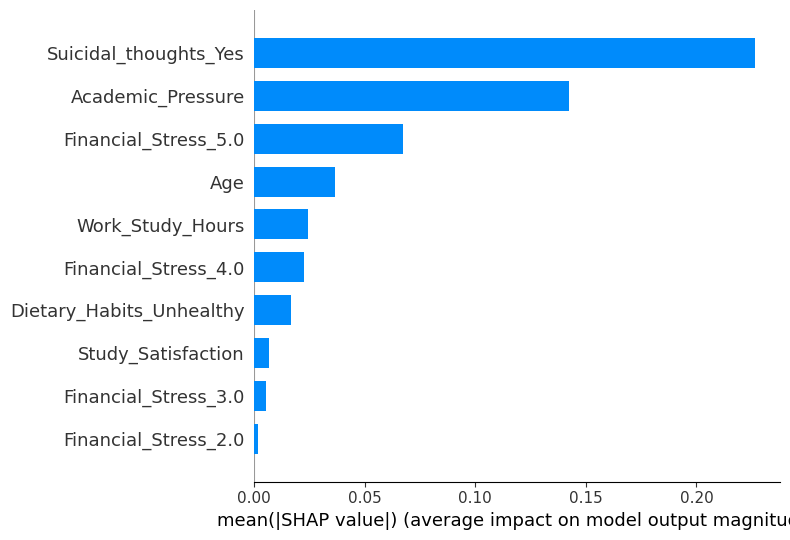

In [ ]:
# Summary Plot -- Bar Chart
shap.summary_plot(shap_values_class1_bag, X_test, plot_type="bar", feature_names=X_encoded.columns, max_display= 10)

## Random Forest

In [ ]:
# Initialize a TreeExplainer for the Random Forest model
explainer = shap.TreeExplainer(rf, approximate=True) # For quicker runtime
X_sample = X_test.sample(frac=0.05, random_state=42) # Subset the test data

In [ ]:
# Calculate SHAP values for the data
rf_shap_values = explainer.shap_values(X_sample)
# For classifiers, shap_values is a list (one array per class). We'll use class 1 (positive class)
shap_values_class1_rf = rf_shap_values[1]
mean_abs_shap_rf = np.abs(shap_values_class1_rf).mean(axis=0)

In [ ]:
# Summary Plot -- Bar Chart
shap.summary_plot(shap_values_class1_rf , X_sample, plot_type="bar", feature_names=X_encoded.columns, max_display= 10)

# Decision Tree - Worst Performing

In [ ]:
# Initialize a TreeExplainer for the Decision Tree model
explainer = shap.TreeExplainer(clf)

# Calculate SHAP values for the data
dtshap_values = explainer.shap_values(X_test)

In [ ]:
# Summary Plot -- Bar Chart
shap.summary_plot(dtshap_values, X_test, plot_type="bar", feature_names=X_encoded.columns, max_display= 10)

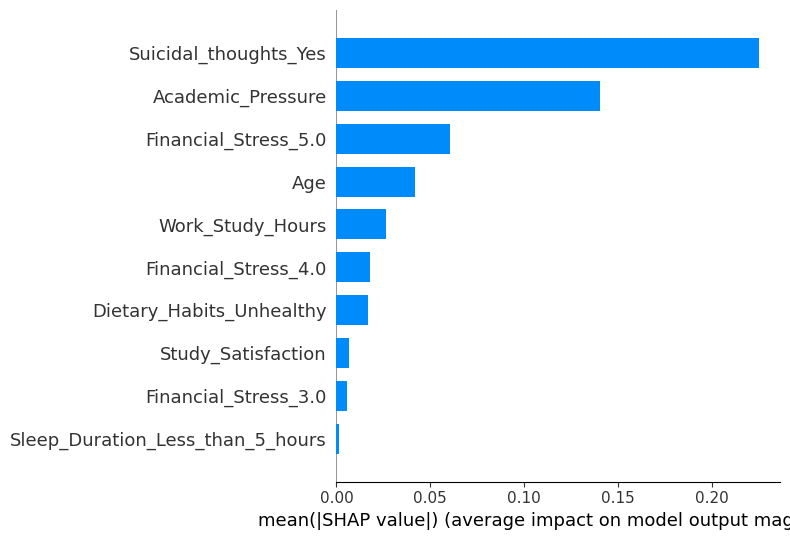

## Model Comparisions

**AUC-ROC curve** is a graph used to check how well a binary classification model works. It helps us to understand how well the model separates the positive cases like people with a depression from the negative cases like people without depression at different threshold level. It shows how good the model is at telling the difference between the two classes by plotting:

**True Positive Rate (TPR):** how often the model correctly predicts the positive cases also known as Sensitivity or Recall.

**False Positive Rate (FPR):** how often the model incorrectly predicts a negative case as positive.

**Specificity:** measures the proportion of actual negatives that the model correctly identifies. It is calculated as 1 - FPR.

The higher the curve the better the model is at making correct predictions (Geeks4Geeks).

In [31]:
# Calculate AUC scores
auc_bag = roc_auc_score(y_test, y_pred_bag)
auc_dt = roc_auc_score(y_test, y_pred_dt)
auc_rf = roc_auc_score(y_test, y_pred_rf)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)


print("AUC (Bagging):", auc_bag)
print("AUC (Decision Tree):", auc_dt)
print("AUC (Random Forest):", auc_rf)
print("AUC (XGBoost):", roc_auc_score(y_test, y_pred_xgb))

AUC (Bagging): 0.817992029471139
AUC (Decision Tree): 0.7609772722075739
AUC (Random Forest): 0.8239036711690716
AUC (XGBoost): 0.829982005625221


In [32]:
# Calculate ROC curve for each model
fpr_bag, tpr_bag, _ = roc_curve(y_test, y_pred_bag)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)

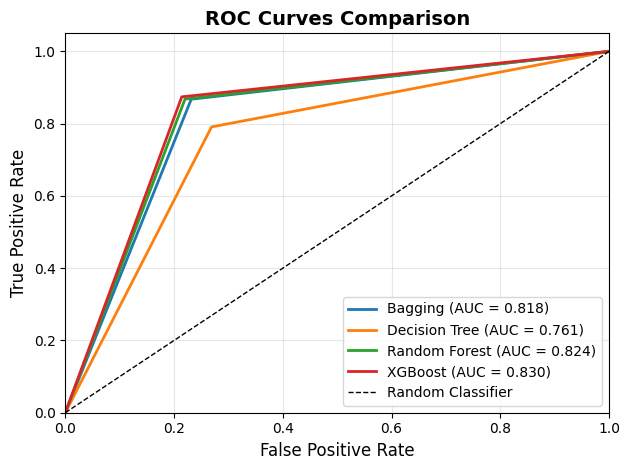

In [33]:
# Plot ROC curves
plt.plot(fpr_bag, tpr_bag, label=f'Bagging (AUC = {auc_bag:.3f})', linewidth=2)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2)

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

# Customize plot
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

## Interpretation of Results

Looking at the evaluation metrics across all four classification models, XGBoost emerges as the best-performing model with an accuracy of 83.72%, followed closely by Random Forest (83.11%) and Bagging (82.61%), while Decision Tree notably underperforms at 76.59%. The XGBoost model demonstrates the most balanced performance with strong precision (0.84) and recall (0.84) across both classes, achieving an F1-score of 0.86 for class 1 (presumably the positive case for depression). The SHAP analysis reveals that suicidal thoughts is by far the most influential predictor, followed by academic pressure and financial stress, which aligns with expected risk factors for student depression.

The Decision Tree's poor performance (with nearly 7% lower accuracy than ensemble methods) highlights the benefits of ensemble learning techniques that reduce overfitting through aggregation. The consistent performance of Random Forest and Bagging (both around 83% accuracy) validates the robustness of bootstrap aggregation approaches. Overall, all ensemble models show good balance between precision and recall for class 1 (0.84-0.87 range), suggesting they can reliably identify students at risk of depression without excessive false positives or false negatives, making **XGBoost the optimal choice for deployment in this mental health prediction scenario.** The ROC curve analysis further confirms XGBoost's superior performance with the highest AUC of 0.830, closely followed by Random Forest (0.824) and Bagging (0.819), while Decision Tree trails significantly at 0.761. The steep initial rise in the ROC curves for all ensemble models indicates excellent discrimination ability at low false positive rates, which is particularly critical in mental health screening where minimizing false alarms while catching true cases is essential.